# Bagging-based estimator

In [1]:
import matplotlib.pyplot as plt
import skrub

skrub.patch_display()  # makes nice display for pandas tables

## Bagging estimator

We see that increasing the depth of the tree leads to an over-fitted model. We can bypass choosing a specific
depth by combining several trees together.

Let’s start by training several trees on slightly different data. We can generate slightly different datasets
by randomly sampling with replacement. In statistics, we call this a bootstrap sample. We will use the iris
dataset to create such an ensemble and keep some data for training and testing.

In [46]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X, y = X[:100], y[:100]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# remark: actually, I think we should shuffle before constraining the data to the first 100 samples, not after

Before to train several decision trees, we will run a single tree. However, instead to train this tree on `X_train`, we want to train it on a bootstrap sample. You can use the `np.random.choice` function sample with replacement some index. You will need to create a sample_weight vector and pass it to the `fit` method of the `DecisionTreeClassifier`. We provide the `generate_sample_weight` function which will generate the `sample_weight` array.

In [3]:
import numpy as np

def bootstrap_idx(X):
    indices = np.random.choice(np.arange(X.shape[0]), size=X.shape[0], replace=True)
    return indices

In [4]:
bootstrap_idx(X_train)

array([ 7, 50, 19, 71, 56, 21, 42, 66, 34, 35, 16, 53,  5,  9, 68,  4, 55,
       30, 59, 29, 55, 38, 69, 68,  7, 34, 70, 10, 13, 12, 73, 74, 24, 39,
        5, 43, 64, 72, 46, 44, 72, 51, 29, 31, 52, 38, 22, 38, 29, 29,  9,
       21, 36,  1, 39, 45,  5,  3,  6,  4,  4, 60,  5, 59, 26, 72, 67, 66,
        2, 32, 71, 74, 60, 69, 54])

In [5]:
from collections import Counter
Counter(bootstrap_idx(X_train))

Counter({np.int64(66): 4,
         np.int64(50): 4,
         np.int64(73): 4,
         np.int64(7): 4,
         np.int64(1): 3,
         np.int64(47): 2,
         np.int64(15): 2,
         np.int64(51): 2,
         np.int64(23): 2,
         np.int64(11): 2,
         np.int64(64): 2,
         np.int64(48): 2,
         np.int64(4): 2,
         np.int64(16): 2,
         np.int64(3): 2,
         np.int64(55): 2,
         np.int64(5): 2,
         np.int64(8): 2,
         np.int64(39): 2,
         np.int64(34): 1,
         np.int64(59): 1,
         np.int64(62): 1,
         np.int64(18): 1,
         np.int64(33): 1,
         np.int64(28): 1,
         np.int64(56): 1,
         np.int64(53): 1,
         np.int64(19): 1,
         np.int64(65): 1,
         np.int64(12): 1,
         np.int64(49): 1,
         np.int64(30): 1,
         np.int64(42): 1,
         np.int64(32): 1,
         np.int64(6): 1,
         np.int64(22): 1,
         np.int64(10): 1,
         np.int64(24): 1,
         np.int64(4

In [6]:
def bootstrap_sample(X, y):
    indices = bootstrap_idx(X)
    return X[indices], y[indices]

In [7]:
X_train_bootstrap, y_train_bootstrap = bootstrap_sample(X_train, y_train)

X_train_bootstrap[:3], y_train_bootstrap[:3]

(array([[5.6, 3. , 4.1, 1.3],
        [4.8, 3.4, 1.6, 0.2],
        [5.1, 3.8, 1.5, 0.3]]),
 array([1, 0, 0]))

In [8]:
print(f'Classes distribution in the original data: {Counter(y_train)}')
print(f'Classes distribution in the bootstrap: {Counter(y_train_bootstrap)}')

Classes distribution in the original data: Counter({np.int64(1): 38, np.int64(0): 37})
Classes distribution in the bootstrap: Counter({np.int64(0): 38, np.int64(1): 37})


<div class="alert alert-success">
    <b>EXERCISE: Create a bagging classifier</b>:
    <br>
    A bagging classifier will train several decision tree classifiers, each of them on a different bootstrap sample.
     <ul>
      <li>
          Create several <tt>DecisionTreeClassifier</tt> and store them in a Python list;
      </li>
      <li>
          Loop over these trees and <tt>fit</tt> them by generating a bootstrap sample using <tt>bootstrap_sample</tt> function;
      </li>
      <li>
          To predict with this ensemble of trees on new data (testing set), you can provide the same set to each tree and call the <tt>predict</tt> method. Aggregate all predictions in a NumPy array;
      </li>
      <li>
          Once the predictions available, you need to provide a single prediction: you can retain the class which was the most predicted which is called a majority vote;
      </li>
      <li>
          Finally, check the accuracy of your model.
      </li>
    </ul>
</div>

In [41]:
# my solution
from sklearn.tree import DecisionTreeClassifier

fitted_trees_list = []

for i in range(10):
    tree = DecisionTreeClassifier(max_depth=2)
    X_train_bootstrap, y_train_bootstrap = bootstrap_sample(X_train, y_train)
    tree.fit(X_train_bootstrap, y_train_bootstrap)
    fitted_trees_list.append(tree)

fitted_trees_list

[DecisionTreeClassifier(max_depth=2),
 DecisionTreeClassifier(max_depth=2),
 DecisionTreeClassifier(max_depth=2),
 DecisionTreeClassifier(max_depth=2),
 DecisionTreeClassifier(max_depth=2),
 DecisionTreeClassifier(max_depth=2),
 DecisionTreeClassifier(max_depth=2),
 DecisionTreeClassifier(max_depth=2),
 DecisionTreeClassifier(max_depth=2),
 DecisionTreeClassifier(max_depth=2)]

In [42]:
# my solution

predictions = None 

for tree in fitted_trees_list:
    new_prediction = tree.predict(X_test).reshape(-1,1)
    if predictions is None: # first call
        predictions = new_prediction
    else:
        predictions = np.hstack((predictions, new_prediction))


predictions.shape

(25, 10)


This would be a more efficient way to do the same thing:

```py
predictions = np.zeros((len(X_test), len(fitted_trees_list)), dtype=int)

for i, tree in enumerate(fitted_trees_list):
    predictions[:, i] = tree.predict(X_test)
```


In [43]:
predictions 

# this is an issue: all these shallow trees do predict the same class; this makes the whole bagging approach
# unnecessary

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [44]:
# my solution

from scipy.stats import mode

print(mode(predictions, axis=1))

prediction_by_majority_vote = mode(predictions, axis=1).mode
prediction_by_majority_vote

ModeResult(mode=array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0]), count=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10]))


array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0])

In [13]:
# my solution

from sklearn.metrics import accuracy_score

accuracy_score(y_test, prediction_by_majority_vote)

# at least we see that all these bagged trees were right with their predictions

1.0

In [45]:
# my experiment:

# here I try a higher depth for the trees and see if we get more variability:
import joblib 

fitted_deeper_trees_list = []

for i in range(10):
    tree = DecisionTreeClassifier(max_depth=None)
    X_train_bootstrap, y_train_bootstrap = bootstrap_sample(X_train, y_train)
    tree.fit(X_train_bootstrap, y_train_bootstrap)
    fitted_deeper_trees_list.append(tree)
    print(joblib.hash(tree)) # the fitted trees are definitely different from each other


predictions_deeper = np.zeros((len(X_test), len(fitted_deeper_trees_list)), dtype=int)

for i, tree in enumerate(fitted_deeper_trees_list):
    predictions_deeper[:, i] = tree.predict(X_test)

predictions_deeper

# doubts: if even `max_depth=None` leads to 10 almost equal trees (which leads to 10 exactly equal
# predictions), then either the bagging is not working as supposed or the data is making splitting too easy
# (which in this case would be a bad choice for this task, so I wouldn't assume that)

cc7964f3947028055053bccc43b94ea6
f12e4917000984f5c538ea35a9fe0448
71e5fbcbf5e19d34077a3acfbc637e00
f12e4917000984f5c538ea35a9fe0448
d07e6c0917c97949c5c5fdbe2c45cc13
40fe5b5b2d1ea4938ff5c75416f66b01
8335d7a3ca65dfa3120e0d35aea4a1a0
3c300c6b46d380cf2fc1a45098a8987c
29093cdaeb5d94a240576311dbb7df1f
0ea31310b33dd3d19f64483efa174170


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [48]:
# my experiment:

# let's manipulate the dataset and see if the bagged trees will vary more; the goal is to find out of the bagging
# works as expected

X = np.empty(shape=(75,4)) # random array filled with whatever is in memory
y = np.random.randint(0,2, size=X.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y)

fitted_deeper_trees_list = []

for i in range(10):
    tree = DecisionTreeClassifier(max_depth=None)
    X_train_bootstrap, y_train_bootstrap = bootstrap_sample(X_train, y_train)
    tree.fit(X_train_bootstrap, y_train_bootstrap)
    fitted_deeper_trees_list.append(tree)


predictions_deeper = np.zeros((len(X_test), len(fitted_deeper_trees_list)), dtype=int)

for i, tree in enumerate(fitted_deeper_trees_list):
    predictions_deeper[:, i] = tree.predict(X_test)

predictions_deeper 

# trees return different predictions, but it seems they are making their predictions pretty harshly; they
# don't train well, even though we trained till the end

array([[0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1]])

In [52]:
# my experiment

# trying another data set

from sklearn.datasets import make_classification

X, y = make_classification(n_features=2, n_samples=1000, n_redundant=0, n_informative=1, n_classes=2, n_clusters_per_class=1)

X = np.random.randn(1000, 2)
y = np.random.randint(0, 2, size=(1000,))

X_train, X_test, y_train, y_test = train_test_split(X, y)

fitted_deeper_trees_list = []

for i in range(10):
    tree = DecisionTreeClassifier(max_depth=None)
    X_train_bootstrap, y_train_bootstrap = bootstrap_sample(X_train, y_train)
    tree.fit(X_train_bootstrap, y_train_bootstrap)
    fitted_deeper_trees_list.append(tree)


predictions_deeper = np.zeros((len(X_test), len(fitted_deeper_trees_list)), dtype=int)

for i, tree in enumerate(fitted_deeper_trees_list):
    predictions_deeper[:, i] = tree.predict(X_test)

predictions_deeper[:10, :] # trees return different results

array([[0, 1, 0, 1, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 1]])

<div class="alert alert-success">
    <b>EXERCISE: using scikit-learn</b>:
    <br>
    After implementing your own bagging classifier, use a <tt>BaggingClassifier</tt> from scikit-learn to fit the above data.
</div>

In [55]:
# my solution

from sklearn.ensemble import BaggingClassifier

# making sure we are using the iris data again
X, y = load_iris(return_X_y=True)
X, y = X[:100], y[:100]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

bagging = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=10)
bagging.fit(X_train, y_train)

prediction_by_majority_vote = bagging.predict(X_test)
prediction_by_majority_vote

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0])

In [56]:
# my solution

accuracy_score(y_test, prediction_by_majority_vote)

1.0

### Note regarding the base estimator

In the previous section, we used decision tree as a base estimator in the bagging ensemble. However, this method can accept any kind of base estimator. We will compare two bagging models: one that uses decision tree and another that uses a linear model with a preprocessing step.

Let's first create a synthetic regression dataset.

In [20]:
import pandas as pd

# Create a random number generator to set the randomness
rng = np.random.default_rng(1)

n_samples = 30
x_min, x_max = -3, 3
x = rng.uniform(x_min, x_max, size=n_samples)
noise = 4.0 * rng.normal(size=n_samples)
y = x**3 - 0.5 * (x + 1) ** 2 + noise
y /= y.std()

data_train = pd.DataFrame(x, columns=["Feature"])
data_test = pd.DataFrame(np.linspace(x_max, x_min, num=300), columns=["Feature"])
target_train = pd.Series(y, name="Target")

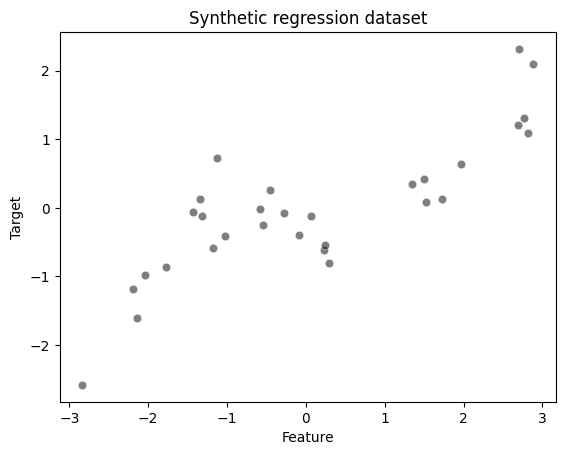

In [21]:
import seaborn as sns

ax = sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
ax.set_title("Synthetic regression dataset")
plt.show()

We will first train a `BaggingRegressor` where the based estimator are `DecisionTreeRegressor`.

In [22]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(n_estimators=50, random_state=0)
bagged_trees.fit(data_train, target_train)

BaggingRegressor(n_estimators=50, random_state=0)

We can make a plot where will show the prediction given by each individual trees and the averaged response given by the baggin regressor.

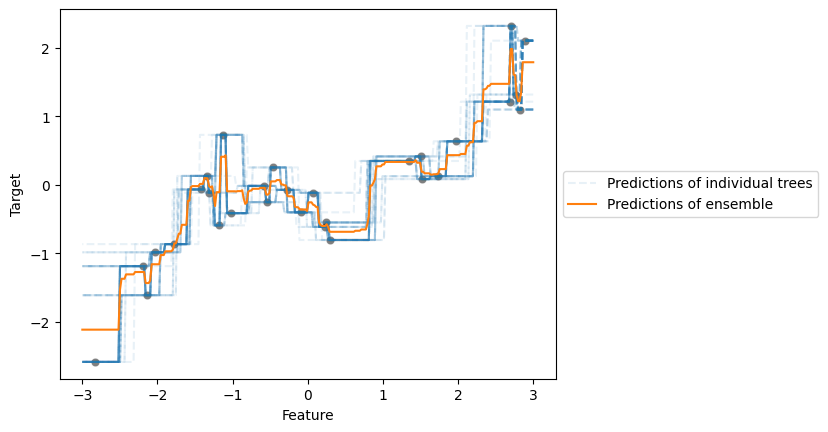

In [23]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    tree_predictions = tree.predict(data_test.to_numpy())
    plt.plot(
        data_test,
        tree_predictions,
        linestyle="--",
        alpha=0.1,
        color="tab:blue",
        label=label,
    )

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(
    data_test,
    bagged_trees_predictions,
    color="tab:orange",
    label="Predictions of ensemble",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Now, we will show that we can use a model other than a decision tree. We will create a model that uses
`PolynomialFeatures` to augment features followed by a `Ridge` linear model.

In [24]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)

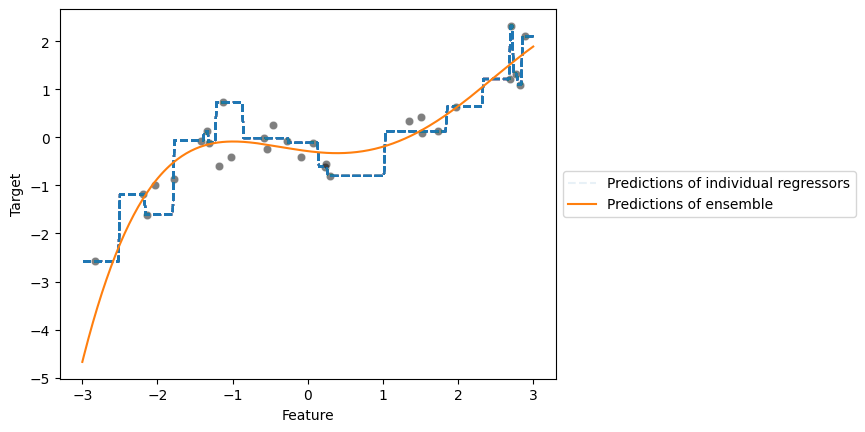

In [25]:
# remark: all the param names are still "tree", except for here, we bag a Ridge with preprocessing; this should be changed

bagged_trees = BaggingRegressor(
    n_estimators=100, estimator=polynomial_regressor, random_state=0
)
bagged_trees.fit(data_train, target_train)

for regressor_idx, regressor in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual regressors" if regressor_idx == 0 else None
    regressor_predictions = tree.predict(data_test.to_numpy())
    plt.plot(
        data_test,
        tree_predictions,
        linestyle="--",
        alpha=0.1,
        color="tab:blue",
        label=label,
    )

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(
    data_test,
    bagged_trees_predictions,
    color="tab:orange",
    label="Predictions of ensemble",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

We can observe that both base estimators can be used to model our toy example.

## Random Forests

### Random forest classifier

The random forest classifier is a popular variant of the bagging classifier. In addition to bootstrap
sampling, random forest uses a random subset of features to find the best split.

<div class="alert alert-success">
    <b>EXERCISE: Create a random forest classifier</b>:
    <br>
    Use your previous code that generated several <tt>DecisionTreeClassifier</tt> instances. Check the classifier options and modify the parameters to use only features for splitting, where $\sqrt{F}$ represents the number of features in the dataset.
</div>

#### # some research

Random Forest is a variant of bagging, but it adds another layer of randomness: for each tree, when it tries to split a node, it only considers a random subset of features (rather than all features). This is done to decorrelate the trees, making the ensemble more robust and diverse.

- usually the square root of the total number of features, $\sqrt{F}$, is considered for each split; with $F$ being the number of features
- this is done with the `max_features` param of `DecisionTreeClassifier`

In [ ]:
# my solution

# making sure we are still using the iris data
X, y = load_iris(return_X_y=True)
X, y = X[:100], y[:100]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

fitted_trees_list = []

for i in range(10):
    # max_features defines that a max of `sqrt(n_features)` are used for splitting:
    tree = DecisionTreeClassifier(max_depth=6, max_features="sqrt")
    X_train_bootstrap, y_train_bootstrap = bootstrap_sample(X_train, y_train)
    tree.fit(X_train_bootstrap, y_train_bootstrap)
    fitted_trees_list.append(tree)


predictions = np.zeros((len(X_test), len(fitted_trees_list)), dtype=int)

for i, tree in enumerate(fitted_trees_list):
    predictions[:, i] = tree.predict(X_test)

predictions

# the trees still all predict the same; something must be wrong?

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [60]:
# my solution

prediction_by_majority_vote = mode(predictions, axis=1).mode

accuracy_score(y_test, prediction_by_majority_vote)

1.0

<div class="alert alert-success">
    <b>EXERCISE: using scikit-learn</b>:
    <br>
    After implementing your own random forest classifier, use a <tt>RandomForestClassifier</tt> from scikit-learn to fit the above data.
</div>

In [61]:
# my solution

from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(max_depth=2) # max_features="sqrt" is a default
randomforest.fit(X_train, y_train)
predictions_randomforest = randomforest.predict(X_test)
predictions_randomforest

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1])

In [62]:
# my solution

accuracy_score(y_test, predictions_randomforest)

# what a surprise!

1.0

### Random forest regressor

<div class="alert alert-success">
    <b>EXERCISE</b>:
    <br>
    <ul>
        <li>Load the datasets available in <tt>sklearn.datasets.fetch_california_housing</tt>.</li>
        <li>Fit a <tt>RandomForestRegressor</tt> with the default parameters.</li>
        <li>What is the number of features used during the training process?</li>
        <li>What is the difference between an <tt>BaggingRegressor</tt> and a <tt>RandomForestRegressor</tt>?</li>
    </ul>
</div>

In [63]:
# my solution

from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# my solution
from sklearn.ensemble import RandomForestRegressor

randomforest = RandomForestRegressor() # by default max_features=1.0, which unintuitively is the same as max_features=n_features
randomforest.fit(X_train, y_train)
predictions_randomforest = randomforest.predict(X_test)
predictions_randomforest


array([1.65283  , 2.54083  , 1.02269  , ..., 2.1899201, 2.53215  ,
       2.35701  ])

In [34]:
# my solution

# What is the number of features used during the training process?

# Per tree trained? It would be `n_features`, because `max_features=1.0`.

In [35]:
# my solution

# What is the difference between a BaggingRegressor and a RandomForestRegressor?

# I think this question is not valid anymore. I found that it's not the same difference as between the
# `BaggingClassifier` and the `RandomForestClassifier`, since `max_features` is both set to the same default (to
# take all features into account) here. But it was different until version 1.1, so now they seem to be equal?

### Hyperparameters

The hyperparameters having an impact on the training process will mainly be the same than for the decision tree. One can look at the documentation. However, since we are dealing with a forest of trees, there is a new parameter `n_estmators`. We can quickly make an exercise to check the effect of modifying this parameter. For this matter, we will use a validation curve.

In [66]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

<div class="alert alert-success">
    <b>EXERCISE</b>:
    <br>
    <ul>
        <li>Use the <tt>sklearn.model_selection.validation_curve</tt> to compute the train and test scores and thus analyse the impact of the `n_estimators` parameter. You will have to define a range of values for this parameter.</li>
        <li>Plot the train and test scores as well as the confidence intervals.</li>
    </ul>
    What is the impact of increasing the number of trees in the ensemble in terms of statistical performance? Do you think that there is a trade-off with the computational performance?
</div>

In [72]:
# my solution

from sklearn.model_selection import validation_curve

X_train, X_test, y_train, y_test = train_test_split(X, y)

randomforest = RandomForestRegressor()
param_name, param_range = "n_estimators", (2,10,20,30,40,50)

train_scores, test_scores = validation_curve(randomforest, X, y, param_name=param_name, param_range=param_range)

print(f"The average train accuracy is {train_scores.mean():.2f}")
print(f"The average test accuracy is {test_scores.mean():.2f}")

print(f"train_scores: {train_scores}")
print(f"test_scores: {test_scores}")

The average train accuracy is 0.96
The average test accuracy is 0.62
train_scores: [[0.91513798 0.91718412 0.91779666 0.91936237 0.92213651]
 [0.96282489 0.964592   0.96633372 0.96380496 0.96343353]
 [0.96950118 0.97145661 0.9694651  0.96943103 0.97120596]
 [0.97135909 0.97224764 0.97269423 0.97234619 0.97283706]
 [0.97238538 0.97302858 0.97344487 0.97294597 0.97401854]
 [0.97297316 0.97390969 0.97433213 0.97354531 0.97490878]]
test_scores: [[0.3416921  0.5684927  0.58357339 0.50776288 0.56590998]
 [0.50866083 0.67527275 0.70769882 0.59232222 0.65761155]
 [0.50617202 0.69521576 0.72664806 0.58368377 0.66101903]
 [0.51943068 0.69862437 0.73266647 0.60696021 0.67833057]
 [0.50489107 0.70276171 0.73485204 0.61883525 0.67551278]
 [0.51125547 0.70059087 0.73602365 0.61509494 0.6827774 ]]


In [74]:
# my solution

# Skipping the plotting. It is enough to look at the test scores by eyes to see there is a sweet spot for test
# score performance and we need at least a certain number of estimators for randomforest or bagging to work
# yield benefit.

The other parameters controlling the tree individual trees overfitting could also be tuned. Sometimes, there is no need to have fully grown trees. However, be aware that with random forest, trees are generally deep since we are seeking to overfit the learners on the bootstrap samples because this will be mitigated by combining them. Assembling underfitted trees (i.e. shallow trees) might also lead to an underfitted forest.